In [5]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.image as mpimg

In [6]:
image = mpimg.imread('../Image/yard.png')

Optimized Sprinkler Positions: [ 7.37774841 10.37774841  5.37774841 17.87774841 14.87774841  7.87774841
 25.5833     19.75       25.03736503 14.56081528]


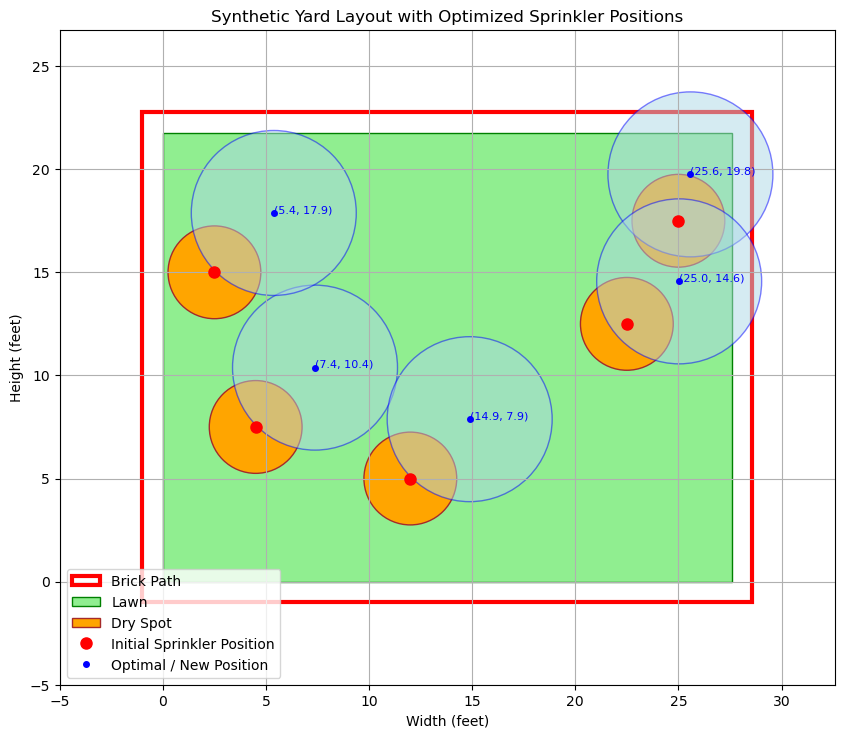

In [9]:
# Yard Dimensions
yard_width = 27.5833  # feet
yard_height = 21.75    # feet

# Define the coordinates for dry spots in feet
dry_spot_coordinates = [(4.5, 7.5), (2.5, 15), (12, 5), (25, 17.5), (22.5, 12.5)]

# Dry radius
dry_radius = 2.25  # 4.5 feet diameter for dry spots
sprinkler_radius = 4.0  # 8 feet diameter for sprinklers

# Objective function to maximize: minimize distance to dry spots
def total_dry_area(positions):
    total_distance = 0
    for i in range(0, len(positions), 2):
        x, y = positions[i], positions[i + 1]
        for dry_x, dry_y in dry_spot_coordinates:
            distance = np.sqrt((x - dry_x) ** 2 + (y - dry_y) ** 2)
            total_distance += max(0, dry_radius - distance)  # Only count overlap
    return total_distance  # Minimize this value

# Constraints: Sprinkler must stay within the lawn's bounds with an additional buffer
def boundary_constraint(positions):
    constraints = []
    buffer_distance = 2.0  # Buffer of 2 feet to ensure we are not wasting water
    for i in range(0, len(positions), 2):
        x, y = positions[i], positions[i + 1]
        constraints.append(x - buffer_distance)  # x must be >= buffer_distance
        constraints.append(y - buffer_distance)  # y must be >= buffer_distance
        constraints.append(yard_width - x - buffer_distance)  # x must be <= yard_width - buffer_distance
        constraints.append(yard_height - y - buffer_distance)  # y must be <= yard_height - buffer_distance
    return constraints

# Minimum distance constraint between sprinklers
def distance_constraint(positions):
    num_sprinklers = len(positions) // 2
    distances = []
    for i in range(num_sprinklers):
        for j in range(i + 1, num_sprinklers):
            x1, y1 = positions[2 * i], positions[2 * i + 1]
            x2, y2 = positions[2 * j], positions[2 * j + 1]
            distance = np.sqrt((x1 - x2) ** 2 + (y1 - y2) ** 2)
            distances.append(distance - 5.0)  # Ensure distance is greater than 5.0 feet
    return distances

# Initial positions for the sprinklers
initial_positions = [4.5, 7.5, 2.5, 15, 12, 5, 25, 17.5, 22.5, 12.5]

# Set up the boundary constraints for all sprinklers
cons = [{'type': 'ineq', 'fun': lambda pos: boundary_constraint(pos)}]
cons.append({'type': 'ineq', 'fun': distance_constraint})

# Minimize the total dry area (i.e., minimize distance to dry spots)
result = minimize(total_dry_area, initial_positions, constraints=cons)

# Optimized positions
optimal_positions = result.x
print(f"Optimized Sprinkler Positions: {optimal_positions}")

# Time to graph the lawn
fig, ax = plt.subplots(figsize=(10, 10))

# Drawing brick path outlining the lawn
path_border = 1
brick_path = patches.Rectangle((-path_border, -path_border), 
                               yard_width + 2 * path_border, 
                               yard_height + 2 * path_border, 
                               edgecolor='red', facecolor='none', linewidth=3, label='Brick Path')
ax.add_patch(brick_path)

# Draw the lawn
lawn = patches.Rectangle((0, 0), yard_width, yard_height, edgecolor='green', facecolor='lightgreen', label='Lawn')
ax.add_patch(lawn)

# Draw dry spots (circles) with a diameter of 4.5 feet (radius = 2.25 feet)
for x_feet, y_feet in dry_spot_coordinates:
    dry_spot = patches.Circle((x_feet, y_feet), dry_radius, edgecolor='brown', facecolor='orange', label='Dry Spot')
    ax.add_patch(dry_spot)

# Plot initial sprinkler positions
for x_feet, y_feet in dry_spot_coordinates:
    ax.plot(x_feet, y_feet, 'ro', markersize=8, label='Initial Sprinkler Position')

# Plot optimized sprinkler positions as large blue circles with 8 feet diameter
for i in range(0, len(optimal_positions), 2):
    x_opt = optimal_positions[i]
    y_opt = optimal_positions[i + 1]
    
    # Circle around the optimized positions
    ax.add_patch(patches.Circle((x_opt, y_opt), sprinkler_radius, edgecolor='blue', facecolor='lightblue', alpha=0.5))  # Large blue circles
    # Annotation for the optimized position
    ax.annotate(f'({x_opt:.1f}, {y_opt:.1f})', (x_opt, y_opt), color='blue', fontsize=8)

    # Dot for the optimal position
    ax.plot(x_opt, y_opt, 'bo', markersize=4, label='Optimal / New Position')

ax.set_xlim(-5, yard_width + 5)
ax.set_ylim(-5, yard_height + 5)
ax.set_aspect('equal', adjustable='box')
ax.set_title('Synthetic Yard Layout with Optimized Sprinkler Positions')
ax.set_xlabel('Width (feet)')
ax.set_ylabel('Height (feet)')

handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys())

plt.grid()
plt.show()